
The original program is written by Eric Ma and the codes can be found located at https://github.com/ericmjl/flu-sequence-predictor/

This program is a modified version.<br>

In flu-test.ipynb, I tested H3N2 flu data from 2000 to 2014. In this program, I try to apply modify flu-test.ipynb for the data including Swine Flu in 2009.

Two set of H1N1 protein data were downloaded: pandemic (pH1N1) and non-pandemic (xpH1N1).



In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import tensorflow as tf
import pymc3 as pm
import gpflow

plt.style.use('fivethirtyeight')


from Bio import SeqIO
from copy import deepcopy
from custom import load_model
from datetime import datetime
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model, model_from_json
from keras import backend as K
from keras import objectives
from keras.callbacks import EarlyStopping
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from random import sample

from Levenshtein import distance as levD
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from pymc3 import gp
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean as eucD

from custom import encode_array, save_model, get_density_interval
from utils.data2 import load_sequence_and_metadata

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Let's start by loading the protein sequence FASTA file and metadata.
sequences_xpH1N1, metadata_xpH1N1 = load_sequence_and_metadata(kind='xpH1N1')
sequences_pH1N1, metadata_pH1N1 = load_sequence_and_metadata(kind='pH1N1')
sequences = sequences_xpH1N1

metadata_xpH1N1 = metadata_xpH1N1[metadata_xpH1N1['Complete Genome'] == 'Yes']
metadata_xpH1N1 = metadata_xpH1N1[metadata_xpH1N1['Host Species'] == 'IRD:Human']
metadata_pH1N1 = metadata_pH1N1[metadata_pH1N1['Complete Genome'] == 'Yes']
metadata_pH1N1 = metadata_pH1N1[metadata_pH1N1['Host Species'] == 'IRD:Human']
metadata = metadata_xpH1N1

#Testing data: >=1.11.2009 and <=10.8.2010 
training_metadata = metadata[metadata['Collection Date'] < datetime(2009, 11, 1)]
#tempX = datetime(2018, 8, 10)
#training_metadata = metadata[metadata['Collection Date'] < tempX]
training_idxs = [i for i, s in enumerate(sequences) if s.id in training_metadata['Sequence Accession'].values]

test_metadata = metadata_pH1N1[(metadata_pH1N1['Collection Date'] >= datetime(2009, 11, 1)) & (metadata_pH1N1['Collection Date'] < datetime(2010, 8, 10))]
#test_metadata = metadata_pH1N1[(metadata_pH1N1['Collection Date'] < tempX)]
test_idxs = [i for i, s in enumerate(sequences_pH1N1) if s.id in test_metadata['Sequence Accession'].values]

# Encode as array. 
sequence_array = encode_array(sequences)
sequence_array_pH1N1 = encode_array(sequences_pH1N1)

training_array = sequence_array[training_idxs]
test_array = sequence_array_pH1N1[test_idxs]

training_sequences = [sequences[i] for i in training_idxs]
test_sequences = [sequences_pH1N1[i] for i in test_idxs]

print("len(training_array)",len(training_array))
print("len(training_metadata)",len(training_metadata))
print("len(test_array)",len(test_array))
print("len(test_metadata)",len(test_metadata))

assert len(training_array) == len(training_metadata)
assert len(test_array) == len(test_metadata)

print("end of part 1")

/home/shinelink/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/shinelink/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Using TensorFlow backend.


load_sequence_and_metadata() took 0:00:00.536334 seconds.
load_sequence_and_metadata() took 0:00:01.271632 seconds.
len(training_array) 1112
len(training_metadata) 1112
len(test_array) 1045
len(test_metadata) 1045
end of part 1


Train on 834 samples, validate on 278 samples
Epoch 1/250
834/834 [==============================] - 2s 2ms/step - loss: 7828.6982 - val_loss: 3991.0844
Epoch 2/250
834/834 [==============================] - 2s 2ms/step - loss: 2086.1765 - val_loss: 1365.2388
Epoch 3/250
834/834 [==============================] - 1s 2ms/step - loss: 1237.8730 - val_loss: 1109.5641
Epoch 4/250
834/834 [==============================] - 1s 2ms/step - loss: 1019.9589 - val_loss: 952.0368
Epoch 5/250
834/834 [==============================] - 1s 1ms/step - loss: 891.6458 - val_loss: 846.2407
Epoch 6/250
834/834 [==============================] - 1s 2ms/step - loss: 798.9086 - val_loss: 766.8866
Epoch 7/250
834/834 [==============================] - 1s 2ms/step - loss: 728.1601 - val_loss: 705.0106
Epoch 8/250
834/834 [==============================] - 1s 1ms/step - loss: 672.0570 - val_loss: 655.0928
Epoch 9/250
834/834 [==============================] - 1s 2ms/step - loss: 626.4211 - val_loss: 613.9387
Ep

Epoch 78/250
834/834 [==============================] - 2s 2ms/step - loss: 155.3769 - val_loss: 157.8009
Epoch 79/250
834/834 [==============================] - 2s 2ms/step - loss: 154.0851 - val_loss: 156.5305
Epoch 80/250
834/834 [==============================] - 1s 1ms/step - loss: 152.7589 - val_loss: 155.1423
Epoch 81/250
834/834 [==============================] - 1s 2ms/step - loss: 151.4392 - val_loss: 153.8557
Epoch 82/250
834/834 [==============================] - 1s 2ms/step - loss: 150.1402 - val_loss: 152.5327
Epoch 83/250
834/834 [==============================] - 1s 1ms/step - loss: 148.9689 - val_loss: 151.4197
Epoch 84/250
834/834 [==============================] - 1s 2ms/step - loss: 147.8220 - val_loss: 150.7522
Epoch 85/250
834/834 [==============================] - 1s 1ms/step - loss: 146.7418 - val_loss: 148.9634
Epoch 86/250
834/834 [==============================] - 1s 2ms/step - loss: 145.4563 - val_loss: 147.7027
Epoch 87/250
834/834 [========================

834/834 [==============================] - 1s 2ms/step - loss: 88.0360 - val_loss: 90.7985
Epoch 156/250
834/834 [==============================] - 2s 2ms/step - loss: 87.4911 - val_loss: 90.2756
Epoch 157/250
834/834 [==============================] - 1s 2ms/step - loss: 86.9533 - val_loss: 89.7354
Epoch 158/250
834/834 [==============================] - 1s 2ms/step - loss: 86.4191 - val_loss: 89.2115
Epoch 159/250
834/834 [==============================] - 2s 2ms/step - loss: 85.8898 - val_loss: 88.6685
Epoch 160/250
834/834 [==============================] - 1s 2ms/step - loss: 85.3643 - val_loss: 88.1489
Epoch 161/250
834/834 [==============================] - 2s 2ms/step - loss: 84.8497 - val_loss: 87.6519
Epoch 162/250
834/834 [==============================] - 2s 2ms/step - loss: 84.3511 - val_loss: 87.1720
Epoch 163/250
834/834 [==============================] - 1s 2ms/step - loss: 83.8878 - val_loss: 86.6545
Epoch 164/250
834/834 [==============================] - 2s 2ms/step 

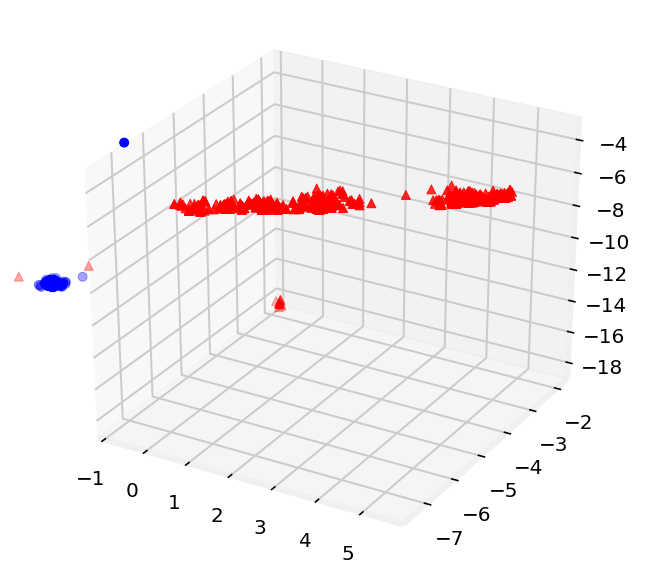

In [2]:
assert (training_array.shape[1]==test_array.shape[1])

# # Set up VAE.
# with tf.device('/gpu:0'):
intermediate_dim = 1000
encoding_dim = 3
latent_dim = encoding_dim
epsilon_std = 1.0
nb_epoch = 250

# one viral sequence as input.
x = Input(shape=(training_array.shape[1],))
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


def vae_loss(x, x_decoded_mean):
    xent_loss = training_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_decoded_mean = Dense(training_array.shape[1], activation='sigmoid')(z_mean)

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder_var = Model(x, z_log_var)

# from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(training_array)

early_stopping = EarlyStopping(monitor="val_loss", patience=2)

# build the decoder, the encoding_dim (dimension of input of decoder) should be 
# the same as the latent variable.
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = vae.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))


# Train the VAE to learn weights
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        validation_data=(x_test, x_test),
        callbacks=[early_stopping],
       )

save_model(vae, 'trained_models/vae')
save_model(encoder, 'trained_models/encoder')
save_model(decoder, 'trained_models/decoder')


with open('trained_models/vae.yaml', 'r+') as f:
    yaml_spec = f.read()
    
#load_model is a class in custom.py at the current directory
vae = load_model('./trained_models/vae')
encoder = load_model('./trained_models/encoder')
decoder = load_model('./trained_models/decoder')

training_embeddings_mean = encoder.predict(training_array)
training_embeddings_mean.shape

test_embeddings_mean = encoder.predict(test_array)
test_embeddings_hull = ConvexHull(test_embeddings_mean)
pd.DataFrame(test_embeddings_mean)


lowp, highp = get_density_interval(99, training_embeddings_mean, axis=0)
lowp, highp

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(training_embeddings_mean[:, 0], 
           training_embeddings_mean[:, 1], 
           training_embeddings_mean[:, 2], 
           c='red', marker='^')     

ax.scatter(test_embeddings_mean[:, 0], 
           test_embeddings_mean[:, 1], 
           test_embeddings_mean[:, 2], 
           c='blue', marker='o')     

# set the x,y,z limit    
ax.set_xlim(lowp[0], highp[0])
ax.set_ylim(lowp[1], highp[1])
ax.set_zlim(lowp[2], highp[2])
ax.set_facecolor('white')
plt.show()


/home/shinelink/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/shinelink/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0,0.5,'Euclidean Distance')

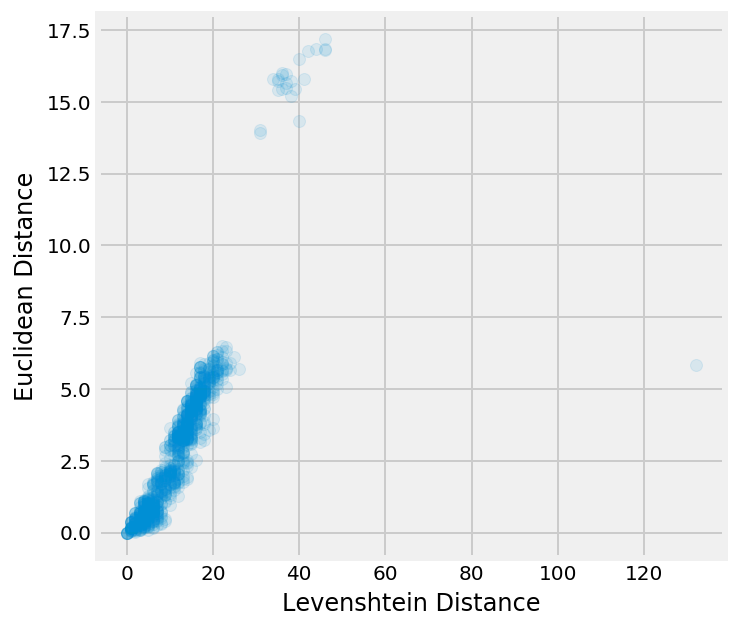

In [3]:
'''
Euclidean and Levenshtein distances relationship)
'''
training_metadata.head()
training_metadata.loc[:, 'coords0'] = training_embeddings_mean[:, 0]
training_metadata.loc[:, 'coords1'] = training_embeddings_mean[:, 1]
training_metadata.loc[:, 'coords2'] = training_embeddings_mean[:, 2]
training_metadata.tail()
# training_metadata.to_csv('data/metadata_with_embeddings.csv')

# Generate pairs of random indices (sample 1000 pairs of sequences)
# you may refer to numpy_test.ipynb for reference.
indices = np.random.randint(low=0, high=len(training_array), size=(1000, 2))
indices # display content

lev_dists = []
euc_dists = []

for i1, i2 in indices:
    lev_dist = levD(str(training_sequences[i1].seq), str(training_sequences[i2].seq))
    euc_dist = eucD(training_embeddings_mean[i1], training_embeddings_mean[i2])
    
    lev_dists.append(lev_dist)
    euc_dists.append(euc_dist)
    
fig = plt.figure(figsize=(5,5))
plt.scatter(lev_dists, euc_dists, alpha=0.1)
plt.xlabel('Levenshtein Distance')
plt.ylabel('Euclidean Distance')

A Jupyter Widget

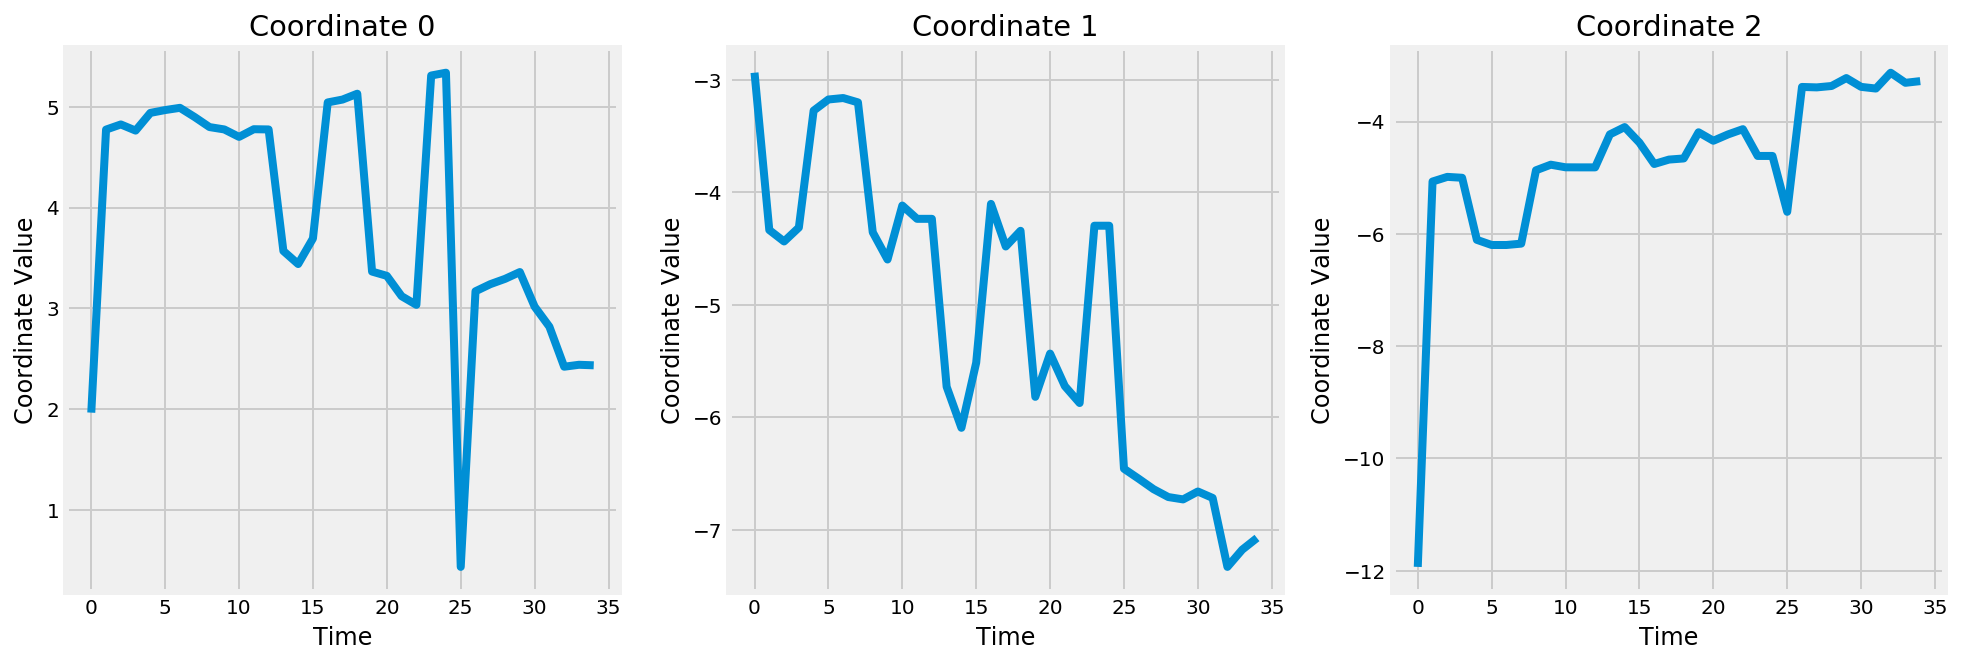

In [4]:

from ipywidgets import interact
from ipywidgets.widgets import Dropdown

# tm_coords means "training metadata with coordinates"
tm_coords = deepcopy(training_metadata)  

tm_coords['coord0'] = training_embeddings_mean[:, 0]
tm_coords['coord1'] = training_embeddings_mean[:, 1]
tm_coords['coord2'] = training_embeddings_mean[:, 2]
avg_coords_by_day = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].median()\
                            .resample("D").median().dropna().reset_index()

avg_coords_by_quarter = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].median().\
                            resample("Q").median().dropna().reset_index()

        
avg_coords_by_week = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].median().\
                            resample("W").median().dropna().reset_index()

        
#Set the elevation and azimuth of the axes for rotating the 
#axes programatically        
@interact(elev=(-180, 180, 10), azim=(0, 360, 10))
def plot_daily_avg(elev, azim):

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.scatter(xs=avg_coords_by_week['coord0'],
                ys=avg_coords_by_week['coord1'],
                zs=avg_coords_by_week['coord2'],
                c=avg_coords_by_week['Collection Date'], 
                cmap='viridis')
    ax1.view_init(elev, azim)
    ax1.set_title('by day')
    
    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.scatter(xs=avg_coords_by_quarter['coord0'], 
                ys=avg_coords_by_quarter['coord1'], 
                zs=avg_coords_by_quarter['coord2'], 
                c=avg_coords_by_quarter['Collection Date'], 
                cmap='viridis')
    ax2.view_init(elev=elev, azim=azim)
    ax2.set_title('by quarter')
    
    ax1.set_xlim(ax2.get_xlim())
    ax1.set_ylim(ax2.get_ylim())
    ax1.set_zlim(ax2.get_zlim())
    
    for simplex in test_embeddings_hull.simplices:
        ax1.plot(test_embeddings_mean[simplex, 0], 
                 test_embeddings_mean[simplex, 1], 
                 test_embeddings_mean[simplex, 2], 
                 'k--', lw=0.2)
        
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')

    plt.show()
    
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(avg_coords_by_quarter['coord0'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(avg_coords_by_quarter['coord1'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(avg_coords_by_quarter['coord2'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

(35, 1) (35,)


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
INFO:pymc3:Initializing NUTS using ADVI...
Average Loss = 61.362:   8%|▊         | 16403/200000 [00:15<02:47, 1092.95it/s]   
Convergence archived at 16500
INFO:pymc3.variational.inference:Convergence archived at 16500
Interrupted at 16,500 [8%]: Average Loss = 63,219
INFO:pymc3.variational.inference:Interrupted at 16,500 [8%]: Average Loss = 63,219
100%|██████████| 1000/1000 [00:07<00:00, 133.17it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
INFO:pymc3:Initializing NUTS using ADVI...


(35, 1) (35,)


Average Loss = 53.834:   8%|▊         | 16242/200000 [00:15<02:58, 1028.02it/s]   
Convergence archived at 16300
INFO:pymc3.variational.inference:Convergence archived at 16300
Interrupted at 16,300 [8%]: Average Loss = 35,062
INFO:pymc3.variational.inference:Interrupted at 16,300 [8%]: Average Loss = 35,062
100%|█████████▉| 2498/2500 [00:20<00:00, 122.81it/s]/home/shinelink/anaconda3/lib/python3.6/site-packages/pymc3-3.1-py3.6.egg/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.879568584399399, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:08<00:00, 119.11it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
INFO:pymc3:Initializing NUTS using ADVI...


(35, 1) (35,)


Average Loss = 68.347:   8%|▊         | 16436/200000 [00:14<02:46, 1103.62it/s]   
Convergence archived at 16500
INFO:pymc3.variational.inference:Convergence archived at 16500
Interrupted at 16,500 [8%]: Average Loss = 59,656
INFO:pymc3.variational.inference:Interrupted at 16,500 [8%]: Average Loss = 59,656
100%|█████████▉| 2497/2500 [00:18<00:00, 133.15it/s]/home/shinelink/anaconda3/lib/python3.6/site-packages/pymc3-3.1-py3.6.egg/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:09<00:00, 108.38it/s]


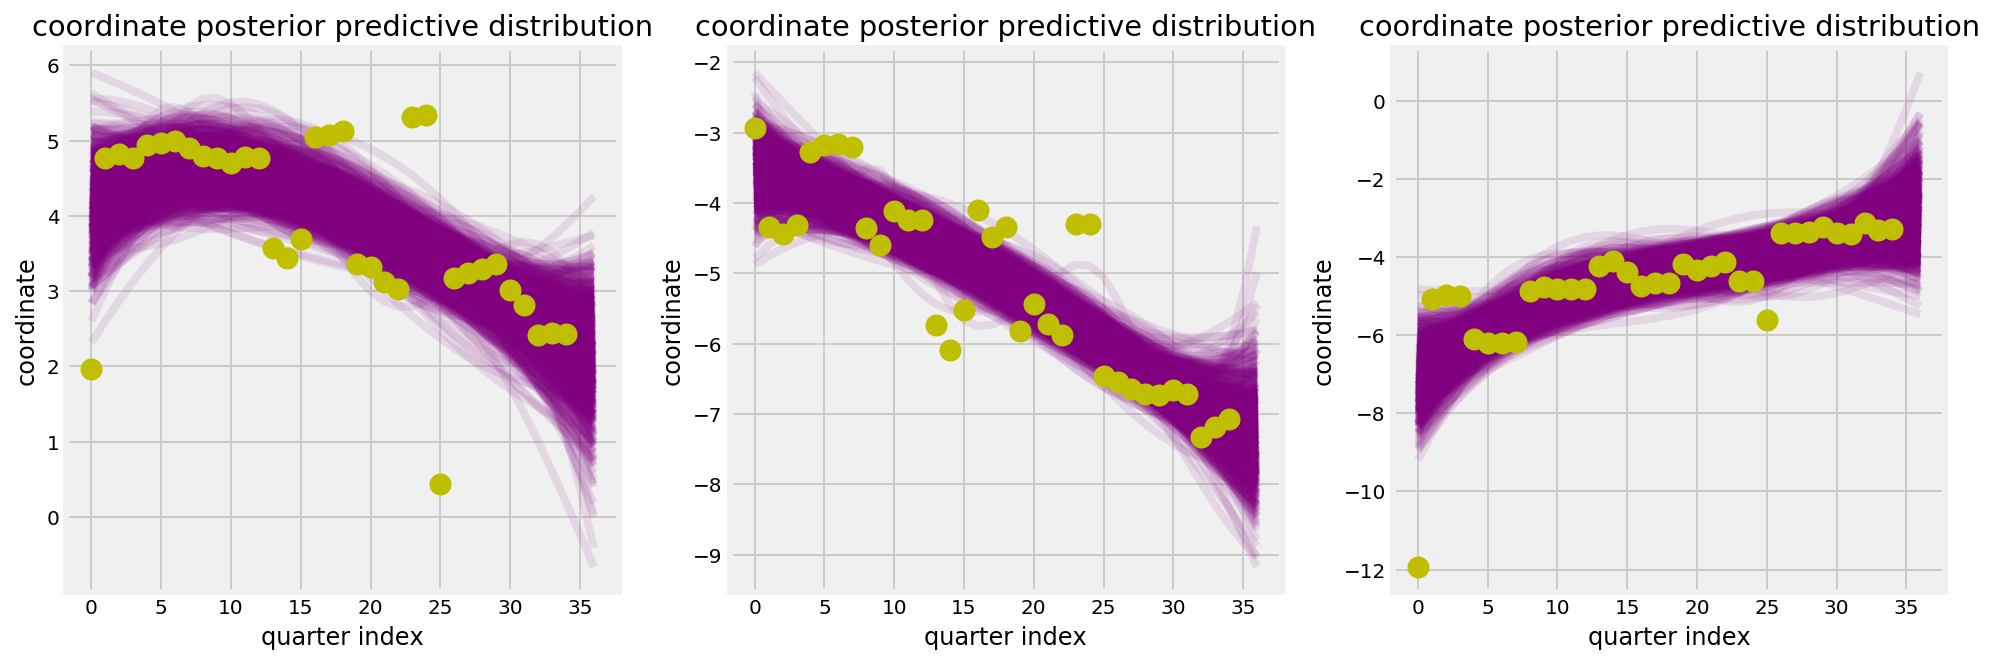

In [5]:

import theano.tensor as tt

x_vals = np.array(range(len(avg_coords_by_quarter))).reshape(-1, 1).astype('float32')

def build_coords_model(coordinate):
    y_vals = avg_coords_by_quarter[coordinate].values.astype('float32')
    
    print(x_vals.shape, y_vals.shape)

    # import pymc3 as pm    
    with pm.Model() as model:
        # l = pm.HalfCauchy('l', beta=20)        
        l = pm.Uniform('l', 0, 30)

        # Covariance function:  covariance is a measure of how much two variables change together
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
                
        s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
        # s2_f = pm.HalfCauchy('s2_f', beta=2)
        # f_cov = s2_f * pm.gp.cov.Matern52(input_dim=1, lengthscales=l)
        # guess: gp --> Gaussian process; cov: covariance function
        # refer: https://docs.pymc.io/api/gp.html
        f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, lengthscales=l)

        # Sigma
        log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
        s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
        # s2_n = pm.HalfCauchy('s2_n', beta=2)

        y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, 
                         observed={'X':x_vals, 
                                   'Y':y_vals})
        trace = pm.sample(2000)

        pp_x = np.arange(len(avg_coords_by_quarter)+2)[:, None]
        gp_samples = pm.gp.sample_gp(trace=trace, gp=y_obs, X_values=pp_x, samples=1000)

    return gp_samples

coord0_preds = build_coords_model('coord0')
coord1_preds = build_coords_model('coord1')
coord2_preds = build_coords_model('coord2')
coord0_preds.shape, coord1_preds.shape, coord2_preds.shape, 

#**************************************
#Now, we can plot the coordinates with the ground truth data.
#**************************************

from random import sample
def plot_coords_with_groundtruth(coord_preds, data, ax):
    pp_x = np.arange(len(avg_coords_by_quarter)+2)[:, None]
    for x in coord_preds:
        ax.plot(pp_x, x, color='purple', alpha=0.1)
    ax.plot(x_vals, data, 'oy', ms=10);
    ax.set_xlabel("quarter index");
    ax.set_ylabel("coordinate");
    ax.set_title("coordinate posterior predictive distribution");
    
    return ax

fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)
plot_coords_with_groundtruth(coord0_preds, avg_coords_by_quarter['coord0'], ax0)
plot_coords_with_groundtruth(coord1_preds, avg_coords_by_quarter['coord1'], ax1)
plot_coords_with_groundtruth(coord2_preds, avg_coords_by_quarter['coord2'], ax2)


In [8]:
test_coords_embed = deepcopy(test_metadata)
test_coords_embed['coord0'] = test_embeddings_mean[:, 0]
test_coords_embed['coord1'] = test_embeddings_mean[:, 1]
test_coords_embed['coord2'] = test_embeddings_mean[:, 2]

test_coords_embed = test_coords_embed.set_index('Collection Date').resample('Q').mean().reset_index()
test_coords_embed.to_csv('data/test_metadata_with_embeddings.csv')
test_coords_embed

decoder.predict(test_coords_embed[['coord0', 'coord1', 'coord2']].values)

from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.layouts import row

def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    return x, y

def percentile_xy(x, y, perc):
    return np.percentile(x, perc), np.percentile(y, perc)


def plot_forecast_hpd(coord_preds, coords_test, c, quarter):
    
    
    x, y = ecdf(coord_preds[:, -3+quarter])
    y_perc = (y * 100).astype('int')
    df = pd.DataFrame(dict(x=x, y=y, y_perc=y_perc))
    
    df['color'] = df['y_perc'].apply(lambda x: 'red' if x > 2.5 and x < 97.5 else 'blue')
    src = ColumnDataSource(df)

    
    # Instantiate Figure
    p = figure(plot_width=300, plot_height=300, 
               x_axis_label="coordinate value", y_axis_label="cumulative distribution",
               title="")

    # Make scatter plot.
    p.scatter('x', 'y', 
              color='color',
              source=src)
    p.ray(x=[coords_test['coord{0}'.format(c)][quarter-1]], y=[0], angle=np.pi / 2, length=0, line_width=2, color='blue')
#     p.scatter(*percentile_xy(x, y, 2.5), color='red')
#     p.scatter(*percentile_xy(x, y, 97.5), color='red')

    # Add Hover tool
    hovertool = HoverTool()
    hovertool.tooltips = [
        ("Value", "@x"),
        ("Percentile", "@y_perc")
    ]
    p.add_tools(hovertool)

    return p

q = 2
p0 = plot_forecast_hpd(coord0_preds, test_coords_embed, 0, quarter=q)
p1 = plot_forecast_hpd(coord1_preds, test_coords_embed, 1, quarter=q)
p2 = plot_forecast_hpd(coord2_preds, test_coords_embed, 2, quarter=q)

show(row(p0, p1, p2))

test [[ -4.947524   -4.320869  -16.647802 ]
 [ -4.9379964  -4.3112416 -16.605968 ]
 [ -4.914451   -4.3001156 -16.623951 ]
 [ -4.932324   -4.282456  -16.563309 ]]


/home/shinelink/anaconda3/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):
